### Please copy and paste the link below:
https://plot.ly/dashboard/stimura:11/view

### Analysis of a Sample Portfolio accompanied by the Construction of an Interactive Dashboard

#### Using Quandl's API, create a scatter plot for the Efficient Frontier of the portfolio

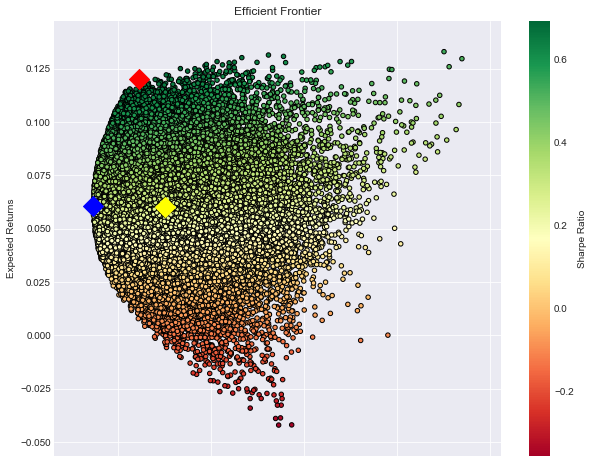

In [6]:
# import needed modules
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# get adjusted closing prices of 5 selected companies with Quandl
quandl.ApiConfig.api_key = '9KMcbJJP1RmTWUvdGsHM'
selected = ['CNP', 'F', 'WMT', 'GE', 'C']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2015-1-1', 'lte': '2017-12-31' }, paginate=True)

# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

# Risk Free Rate
rf_rate = 0.02

# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = (returns - rf_rate) / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

# current portfolio
current_vol = df['Volatility'].mean()
current_returns = df['Returns'].mean()

# min variance portfolio
min_volatility = df['Volatility'].min()
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# max sharpe portfolio
max_sharpe = df['Sharpe Ratio'].max()
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.scatter(x=current_vol, y=current_returns, c='yellow', marker='D', s=200 )

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

#### Using the scatter plot above as a basis, convert the matplotlib chart into a Plotly Object for our dashboard

In [7]:
import plotly.graph_objs as go
import plotly.plotly as py
import numpy as np

trace1 = go.Scatter(
    x = df['Volatility'],
    y = df['Returns'],
    name = 'Portfolios',
    mode='markers',
    marker=dict(
        size='8',
    )
)

trace2 = go.Scatter(
    x=sharpe_portfolio['Volatility'],
    y=sharpe_portfolio['Returns'],
    name = 'Max Sharpe Portfolio',
    mode='markers',
    marker=dict(
        size='16',
        color = 'rgba(255, 255, 0, 1)',
    )
)


trace3 = go.Scatter(
    x=min_variance_port['Volatility'],
    y=min_variance_port['Returns'],
    name = 'Min Variance Portfolio',
    mode='markers',
    marker=dict(
        size='16',
        color = 'rgba(152, 0, 0, 1)',
    )
)

trace40 = go.Scatter(
    x=current_vol,
    y=current_returns,
    name = 'Current Portfolio',
    mode='markers',
    marker=dict(
        size='16',
        color = 'rgba(0, 255, 0, 1)',
    )
)

data = [trace1, trace2, trace3, trace40]

layout= go.Layout(
    title= 'Efficient Frontier',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Volatility (Std. Deviation)',
    ),
    yaxis=dict(
        title= 'Expected Returns',
))

#url_1 = py.plot(data, filename='efficient_frontier', auto_open=False)
#py.iplot(data, filename='scatter-for-dashboard')
fig = go.Figure(data=data, layout=layout)
url_1 = py.plot(data, filename='efficient_frontier', auto_open=False)
py.iplot(fig, filename='efficient_frontier')

/Users/SamTimura/anaconda3/lib/python3.6/site-packages/plotly/plotly/plotly.py:224: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/Users/SamTimura/anaconda3/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



The draw time for this plot will be slow for clients without much RAM.
The draw time for this plot will be slow for clients without much RAM.


### Individual Security Analysis

#### Start by creating a dataframe for each stock by looping through the selected companies and calling the Quandl API

In [8]:
# import needed modules
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# get adjusted closing prices of 5 selected companies with Quandl
quandl.ApiConfig.api_key = '9KMcbJJP1RmTWUvdGsHM'

selected = ['CNP', 'F', 'WMT', 'GE', 'C']

dfs = []

for x in selected:
    name = x + '_df'
    print(name)
    name = quandl.get_table('WIKI/PRICES', ticker = x,
                    qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                    date = { 'gte': '2015-1-1', 'lte': '2017-12-31' }, paginate=True)
    dfs.append(name)

CNP_df
F_df
WMT_df
GE_df
C_df


In [9]:
CNP_df = dfs[0]
F_df = dfs[1]
WMT_df = dfs[2]
GE_df = dfs[3]
C_df = dfs[4]

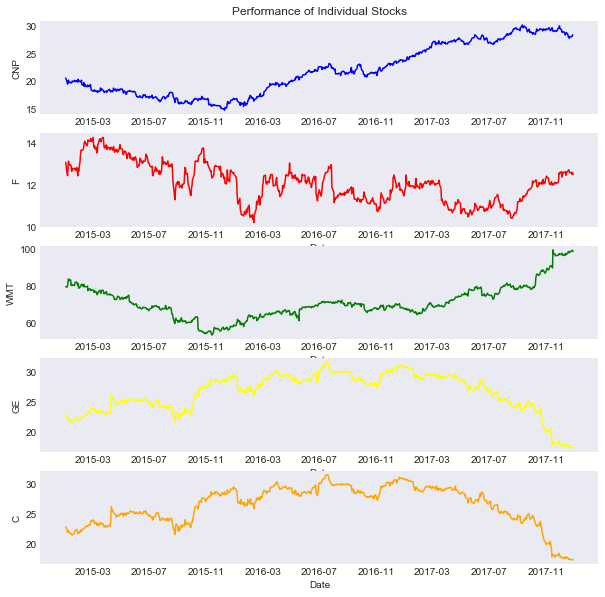

In [10]:
x1 = CNP_df['date']
x2 = F_df['date']
x3 = WMT_df['date']
x4 = GE_df['date']
x5 = C_df['date']

y1 = CNP_df['adj_close']
y2 = F_df['adj_close']
y3 = WMT_df['adj_close']
y4 = GE_df['adj_close']
y5 = C_df['adj_close']

plt.figure(figsize=(10,10))

plt.subplot(5, 1, 1)
plt.plot(x1, y1, color='blue')
plt.title('Performance of Individual Stocks')
plt.ylabel('CNP')

plt.subplot(5, 1, 2)
plt.plot(x2, y2, color='red')
plt.xlabel('Date')
plt.ylabel('F')

plt.subplot(5, 1, 3)
plt.plot(x3, y3, color='green')
plt.xlabel('Date')
plt.ylabel('WMT')

plt.subplot(5, 1, 4)
plt.plot(x4, y4, color='yellow')
plt.xlabel('Date')
plt.ylabel('GE')

plt.subplot(5, 1, 5)
plt.plot(x4, y4, color='orange')
plt.xlabel('Date')
plt.ylabel('C')

plt.show()

#### Now I need to convert the Matplotlib chart to a Plotly object to place in the dashboard

In [11]:
import plotly.graph_objs as go
import plotly.plotly as py
import numpy as np

trace4 = go.Scatter(
    x = x1,
    y = y1,
    name = 'CNP',
    mode='line',
    marker=dict(
        size='8',
    )
)

trace5 = go.Scatter(
    x = x2,
    y = y2,
    name = 'F',
    mode='line',
    marker=dict(
        size='8',
    )
)

trace6 = go.Scatter(
    x = x3,
    y = y3,
    name = 'WMT',
    mode='line',
    marker=dict(
        size='8',
    )
)

trace17 = go.Scatter(
    x = x4,
    y = y4,
    name = 'GE',
    mode='line',
    marker=dict(
        size='8',
    )
)

trace18 = go.Scatter(
    x = x5,
    y = y5,
    name = 'C',
    mode='line',
    marker=dict(
        size='8',
    )
)

data2 = [trace4, trace5, trace6, trace17, trace18]

layout2 = go.Layout(
    title= 'Performance Over Time',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Time',
    ),
    yaxis=dict(
        title= 'Price',
))

fig2 = go.Figure(data=data2, layout=layout2)
url_3 = py.plot(data2, filename='price_over_time', auto_open=False)
py.iplot(fig2, filename='price_over_time')

#### Create variables to hold the returns of the individual stocks

In [12]:
CNP_returns = round(100 * (CNP_df['adj_close'].iloc[-1] - CNP_df['adj_close'].iloc[0]) / CNP_df['adj_close'].iloc[0], 2)
F_returns = round(100 * (F_df['adj_close'].iloc[-1] - F_df['adj_close'].iloc[0]) / F_df['adj_close'].iloc[0], 2)
WMT_returns = round(100 * (WMT_df['adj_close'].iloc[-1] - WMT_df['adj_close'].iloc[0]) / WMT_df['adj_close'].iloc[0], 2)
GE_returns = round(100 * (GE_df['adj_close'].iloc[-1] - GE_df['adj_close'].iloc[0]) / GE_df['adj_close'].iloc[0], 2)
C_returns = round(100 * (C_df['adj_close'].iloc[-1] - C_df['adj_close'].iloc[0]) / C_df['adj_close'].iloc[0], 2)

#### Turn into a Plotly object to place into dashboard

In [13]:
import plotly.plotly as py
import plotly.graph_objs as go

x = ['CNP', 'F', 'WMT', 'GE', 'C']
y = [CNP_returns, F_returns, WMT_returns, GE_returns, C_returns]

trace7 = go.Bar(
    x=x,
    y=y,
    text=y,
    textposition = 'auto',
    marker=dict(
        color=['rgb(158,202,225)', 'rgba(222,45,38,0.8)','rgb(158,202,225)', 'rgba(222,45,38,0.8)', 'rgb(158,202,225)'],
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

data3 = [trace7]

layout3 = go.Layout(
    title='Returns over Time Period (Excluding Dividends)',
)

fig3 = go.Figure(data=data3, layout=layout3)
url_2 = py.plot(data3, filename='stock_returns', auto_open=False)
py.iplot(fig3, filename='stock_returns')

### Creating an Interactive Dashboard

#### First, create the skeleton of the dashboard

In [38]:
import plotly.dashboard_objs as dashboard

import IPython.display
from IPython.display import Image

my_board = dashboard.Dashboard()
my_board.get_preview()

#### Second, create functions to capture the unique ids of my plotly objects so I can place them into the dashboard

In [39]:
import re

def fileId_from_url(url):
    """Return fileId from a url."""
    raw_fileId = re.findall("~[A-z]+/[0-9]+", url)[0][1: ]
    return raw_fileId.replace('/', ':')

def sharekey_from_url(url):
    """Return the sharekey from a url."""
    if 'share_key=' not in url:
        return "This url is not 'sercret'. It does not have a secret key."
    return url[url.find('share_key=') + len('share_key='):]

fileId_1 = fileId_from_url(url_1)
fileId_2 = fileId_from_url(url_2)
fileId_3 = fileId_from_url(url_3)

#### Construction of boxes to place into dashboard

In [40]:
box_a = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_1,
    'title': 'Efficient Frontier'
}

my_board.insert(box_a, 'right', 1)

In [41]:
text_for_box = """ 
## Portfolio Overview:
Timeline: January 1, 2015 to December 31, 2017

### Company Summaries
##### CenterPoint Energy (CNP)
1. Sector: Utilities
2. Market Cap: 12.15B
3. Beta: 0.59
4. P/E: 6.92
5. EPS (TTM): 4.07

##### Ford Motor Company (F)
1. Sector: Consumer Cyclical
2. Market Cap: 39.578B
3. Beta: 0.87
4. P/E: 5.15
5. EPS (TTM): 1.93

##### Walmart Inc. (WMT)
1. Sector: Consumer Defensive
2. Market Cap: 260.058B
3. Beta: 0.40
4. P/E: 29.41
5. EPS (TTM): 3.00

##### General Electric Company (GE)
1. Sector: Industrials
2. Market Cap: 113.431B
3. Beta: 0.71
4. P/E: N/A
5. EPS (TTM): -0.84

##### Citigroup Inc. (C)
1. Sector: Financial Services
2. Market Cap: 180.415B
3. Beta: 1.52
4. P/E: N/A
5. EPS (TTM): -2.83


### Efficient Frontier (Scatter Plot)
1. Set of optimal portfolios that offers the highest expected return given the level of risk
2. Maximum Sharpe Portfolio: Best Risk to Reward Ratio
3. Minimum Standard Deviation Portfolio: Portfolio with the least Risk
4. Current Portfolio (Light Green)
##### Takeaway: Portfolio can be improved by moving towards the efficient frontier

### Individual Returns over Time Period (Excludes Dividends) (Bar Chart)
1. CenterPoint Energy, Walmart, and Citigroup all produced positive returns
2. Ford and General Electric both produced negative returns
3. Citigroup has the highest returns of the portfolio
4. General Electric has the lowest returns of the portfolio

### Performance Over Time (Line Chart)
1. Walmart rallied after a poor performance in the second half of 2015
2. The most volatile of the portfolio, Citigroup rallied after hitting a low in early 2016
3. With little volatility, GE remained leveled around $26
4. After a period of diminishing performance in 2016, CNP started to constantly increase in value
5. Ford experienced a slow decline in value during the given time period

"""

In [42]:
box_b = {
    'type': 'box',
    'boxType': 'text',
    'text': text_for_box,
    'title': 'Markdown Options for Text Box'
}


my_board.insert(box_b, 'left', 1, fill_percent=30)

In [43]:
box_c = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_2,
    'title': 'Stock Returns',
}

my_board.insert(box_c, 'below', 2)

In [44]:
box_d = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_3,
    'title': 'Stock Performance',
}

my_board.insert(box_d, 'below', 3)

#### Clean up the dashboard

In [45]:
stacked_board = dashboard.Dashboard()
text_box = {
    'type': 'box',
    'boxType': 'text',
    'text': 'empty space' 
}
for _ in range(5):
    stacked_board.insert(text_box, 'below', 1)
stacked_board.get_preview()

In [46]:
stacked_board['layout']['size'] = 3000

In [47]:
my_board.get_box(1)['title'] = 'Portfolio Overview'

In [48]:
my_board['settings']['title'] = 'Sample Portfolio Overview'

#### Finally upload my dashboard skeleton to an interactive interface

In [50]:
import plotly.plotly as py
py.dashboard_ops.upload(my_board, 'Portfolio')

'https://plot.ly/~stimura/11/sample-portfolio-overview/'